In [1]:
# ==============================
# ZACH-ViT: Zero-token Adaptive Compact Hierarchical Vision Transformer for Lung Ultrasound
# Paper: https://arxiv.org/abs/XXXX.XXXXX
# Code: https://github.com/Bluesman79/ZACH-ViT
# Licensed under Apache License 2.0
# Author: Athanasios Angelakis
# ==============================

# ==============================
# Imports
# ==============================
import os
# 1) turn off deterministic ops (they trigger the error with XLA on maxpool grads)
os.environ.pop("TF_DETERMINISTIC_OPS", None)    # or: os.environ["TF_DETERMINISTIC_OPS"] = "0"

# 2) fully disable XLA JIT and XLA devices
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false --tf_xla_auto_jit=0"
os.environ.pop("TF_CUDNN_DETERMINISTIC", None)

import tensorflow as tf
# double-disable in-runtime (useful in notebooks)
tf.config.optimizer.set_jit(False)
try:
    tf.config.experimental.enable_op_determinism(False)
except Exception:
    pass

# Enable per-process memory growth (prevents TF from grabbing all VRAM at once)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Memory growth setup error:", e)

from tensorflow.keras.layers import Lambda, Reshape, Dense, Dropout, BatchNormalization, \
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Flatten, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, accuracy_score
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings, time

# reproducibility
np.random.seed(7)
tf.random.set_seed(7)
tf.keras.utils.set_random_seed(7)
warnings.filterwarnings("ignore")

# ==============================
# Callbacks
# ==============================
class PlotTrainingHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'auc': [], 'val_auc': []}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['auc'].append(logs.get('auc'))
        self.history['val_auc'].append(logs.get('val_auc'))

        clear_output(wait=True)
        plt.figure(figsize=(18, 5))

        plt.subplot(1, 3, 1)
        plt.plot(self.history['loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Val Loss')
        plt.legend(); plt.title("Loss")

        plt.subplot(1, 3, 2)
        plt.plot(self.history['accuracy'], label='Train Acc')
        plt.plot(self.history['val_accuracy'], label='Val Acc')
        plt.legend(); plt.title("Accuracy")

        plt.subplot(1, 3, 3)
        plt.plot(self.history['auc'], label='Train AUC')
        plt.plot(self.history['val_auc'], label='Val AUC')
        plt.legend(); plt.title("ROC-AUC")

        plt.show()

class EpochTimeLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        duration = time.time() - self.start_time
        self.epoch_times.append(duration)
        print(f"Epoch {epoch+1} took {duration:.2f} seconds")

    def on_train_end(self, logs=None):
        mean_time = np.mean(self.epoch_times)
        std_time = np.std(self.epoch_times)
        print(f"\nAverage epoch time: {mean_time:.2f} ± {std_time:.2f} seconds "
              f"over {len(self.epoch_times)} epochs\n")

# ==============================
# Data pipeline
# ==============================
def create_data_generators(base_dir, batch_size=128, target_size=(224,224), threshold=93):
    train_dir = os.path.join(base_dir, 'train') #train directory with VIS, or 0_SSDA or SSDA_p iamges
    val_dir   = os.path.join(base_dir, 'val') #validation directory with VIS images
    test_dir  = os.path.join(base_dir, 'test') #test directory having only VIS images

    def thresholding(image):
        image = image.copy()
        image[image < (threshold/255.0)] = 0
        return image

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=thresholding
    )
    val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=thresholding)
    test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=thresholding)

    train_gen = train_datagen.flow_from_directory(train_dir, target_size=target_size,
        batch_size=batch_size, class_mode='binary', seed=7)
    val_gen = val_datagen.flow_from_directory(val_dir, target_size=target_size,
        batch_size=batch_size, class_mode='binary', shuffle=False, seed=7)
    test_gen = test_datagen.flow_from_directory(test_dir, target_size=target_size,
        batch_size=batch_size, class_mode='binary', shuffle=False, seed=7)
    return train_gen, val_gen, test_gen

def evaluate_model_and_create_dfs(model, val_gen, test_gen):
    def predict_and_make_df(generator, name=""):
        preds = model.predict(generator, verbose=0).ravel()
        return pd.DataFrame({
            "Filename": generator.filenames,
            "True Label": generator.classes,
            "Pred Label": (preds > 0.5).astype(int),
            "Pred Proba": preds
        })

    val_df = predict_and_make_df(val_gen, "Validation")
    test_df = predict_and_make_df(test_gen, "Test")
    return val_df, test_df

def print_metrics(df, name="Validation"):
    auc = roc_auc_score(df["True Label"], df["Pred Proba"])
    f1 = f1_score(df["True Label"], df["Pred Label"])
    acc = accuracy_score(df["True Label"], df["Pred Label"])
    tn, fp, fn, tp = confusion_matrix(df["True Label"], df["Pred Label"]).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"{name} - AUC: {auc:.3f}, Accuracy: {acc:.3f}, Sensitivity: {sens:.3f}, Specificity: {spec:.3f}, F1: {f1:.3f}")

# ==============================
# ZACH-ViT
# ==============================
def build_custom_vit_model(input_shape=(224,224,3), patch_size=16, num_heads=8,
                           transformer_units=[128,64], mlp_head_units=[128,64]):
    inputs = Input(shape=input_shape)
    n_h, n_w = input_shape[0]//patch_size, input_shape[1]//patch_size
    num_patches, patch_dims = n_h*n_w, patch_size*patch_size*input_shape[-1]

    patches = Lambda(lambda imgs: tf.image.extract_patches(
        images=imgs, sizes=[1,patch_size,patch_size,1], strides=[1,patch_size,patch_size,1],
        rates=[1,1,1,1], padding="VALID"))(inputs)
    patches = Reshape((num_patches, patch_dims))(patches)
    x = Dense(units=transformer_units[0], activation="relu")(patches)

    for idx, units in enumerate(transformer_units):
        key_dim = max(1, units//num_heads)
        y = LayerNormalization(epsilon=1e-6)(x)
        y = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=0.1)(y,y)
        y = Dropout(0.1)(y)
        if x.shape[-1] != y.shape[-1]:
            x = Dense(y.shape[-1])(x)
        x = x + y

        y = LayerNormalization(epsilon=1e-6)(x)
        y = Dense(units, activation="relu")(y)
        y = Dropout(0.1)(y)
        if x.shape[-1] != y.shape[-1]:
            x = Dense(y.shape[-1])(x)
        x = x + y

    rep = GlobalAveragePooling1D()(x)
    for u in mlp_head_units:
        rep = Dense(u, activation="relu")(rep); rep = Dropout(0.1)(rep)
    logits = Dense(1, activation="sigmoid")(rep)

    model = Model(inputs, logits, name="ZACH-ViT")
    model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy", AUC()], jit_compile=False)
    return model

# ==============================
# Wrappers for training
# ==============================
def run_zach_vit(batch_size=128, epochs=23, class_weights=None, threshold=93, base_dir="../Data/"): #INPUT
    """
    Train and evaluate ZACH-ViT.
    
    Note: For full ShuffleStrides Data Augmentation (SSDA), use the separate 
    preprocessing script to generate augmented datasets (0-SSDA, 0_2-SSDA).
    This function uses basic thresholding only.
    """
    train_gen, val_gen, test_gen = create_data_generators(base_dir, batch_size, threshold=threshold)
    model = build_custom_vit_model((224,224,3))
    
    # Print model info
    print("=== ZACH-ViT Model Summary ===")
    model.summary()
    total_params = model.count_params()
    print(f"\nTotal trainable parameters: {total_params:,} ({total_params/1e6:.2f}M)\n")
    
    model.fit(train_gen, epochs=epochs, validation_data=val_gen,
              callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
                         PlotTrainingHistory(), EpochTimeLogger()],
              class_weight=class_weights, verbose=1)
    
    val_df, test_df = evaluate_model_and_create_dfs(model, val_gen, test_gen)
    
    # Print metrics
    print("\n=== Final Performance ===")
    print_metrics(val_df, "Validation")
    print_metrics(test_df, "Test")
    
    return model, val_df, test_df

2025-10-13 23:15:52.018303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760390152.032596  386212 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760390152.036996  386212 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760390152.048549  386212 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760390152.048569  386212 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760390152.048571  386212 computation_placer.cc:177] computation placer alr

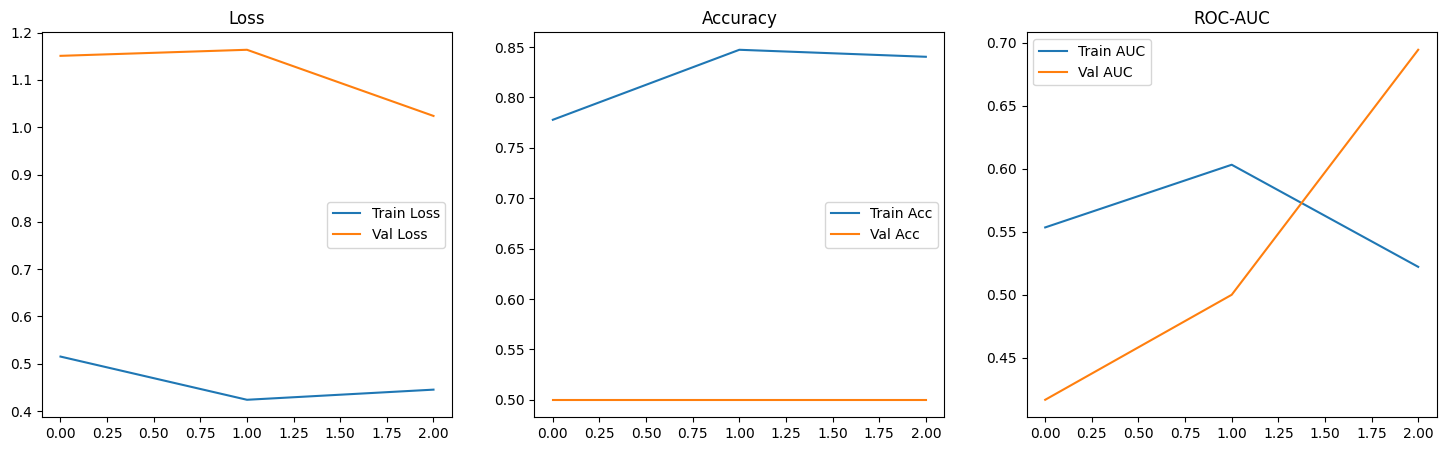

Epoch 3 took 9.90 seconds
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.8415 - auc: 0.4801 - loss: 0.4552 - val_accuracy: 0.5000 - val_auc: 0.6944 - val_loss: 1.0238

Average epoch time: 11.75 ± 2.50 seconds over 3 epochs


=== Final Performance ===
Validation - AUC: 0.764, Accuracy: 0.500, Sensitivity: 1.000, Specificity: 0.000, F1: 0.667
Test - AUC: 0.764, Accuracy: 0.500, Sensitivity: 1.000, Specificity: 0.000, F1: 0.667


In [2]:
 model, val_df, test_df = run_zach_vit(
     batch_size=16, 
     epochs=3, 
     threshold=93,
     base_dir="../Data/"
 )